# Model13

In [1]:
!ln -s ../data/ ./
!ln -s ../out/ ./

In [5]:
import os

data_dir = 'data/'
fname = os.path.join(data_dir, 'dataset_rev4_train_RNN_rev1.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"datetime"', '"I"', '"T"', '"UV"', '"WS"', '"RH"', '"P"']
131587


In [6]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))

In [7]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

ValueError: cannot copy sequence with size 0 to array axis with dimension 6

In [8]:
i

131586

In [9]:
float_data = float_data[:-1, :]

In [10]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

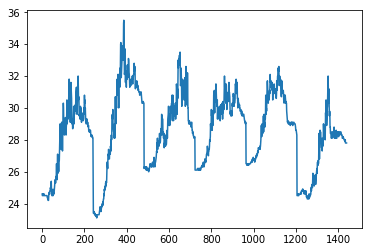

In [11]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [12]:
mean = float_data[:60000].mean(axis=0)
float_data -= mean
std = float_data[:60000].std(axis=0)
float_data /= std

In [13]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [14]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=60000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=60001,
                    max_index=90000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=90001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (90000 - 60001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 90001 - lookback) // batch_size

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

1.480070529874667


In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.6500 - val_loss: 0.9050
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3918 - val_loss: 0.7804
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3471 - val_loss: 0.7871
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3201 - val_loss: 0.7979
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3032 - val_loss: 0.7577
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2882 - val_loss: 0.7783
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2764 - val_loss: 0.7721
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2686 - val_loss: 0.8995
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2615 - val_loss: 0.7856
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2545

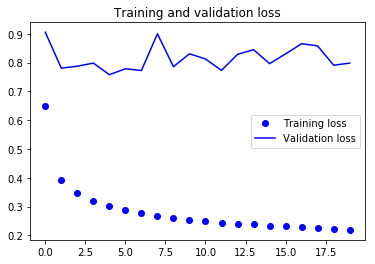

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 137s 273ms/step - loss: 0.5102 - val_loss: 0.7662
Epoch 2/20
500/500 [==============================] - 140s 280ms/step - loss: 0.4537 - val_loss: 0.7608
Epoch 3/20
500/500 [==============================] - 126s 251ms/step - loss: 0.4367 - val_loss: 0.7763
Epoch 4/20
500/500 [==============================] - 139s 278ms/step - loss: 0.4248 - val_loss: 0.7774
Epoch 5/20
500/500 [==============================] - 124s 248ms/step - loss: 0.4144 - val_loss: 0.7801
Epoch 6/20
500/500 [==============================] - 124s 247ms/step - loss: 0.4023 - val_loss: 0.8170
Epoch 7/20
500/500 [==============================] - 124s 247ms/step - loss: 0.3987 - val_loss: 0.8383
Epoch 8/20
500/500 [==============================] - 124s 248ms/step - loss: 0.3884 - val_loss: 0.8198
Epoch 9/20
500/500 [==============================] - 124s 247ms/step - loss: 0.3808 - val_loss: 0.8580
Epoch 10/20
500/500 [==============================] - 123s 247m

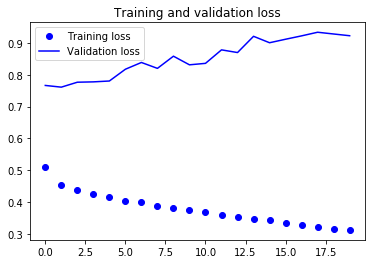

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 139s 278ms/step - loss: 0.5801 - val_loss: 0.7839
Epoch 2/40
500/500 [==============================] - 136s 271ms/step - loss: 0.5179 - val_loss: 0.7610
Epoch 3/40
500/500 [==============================] - 135s 271ms/step - loss: 0.4966 - val_loss: 0.7255
Epoch 4/40
500/500 [==============================] - 135s 270ms/step - loss: 0.4855 - val_loss: 0.7193
Epoch 5/40
500/500 [==============================] - 135s 269ms/step - loss: 0.4784 - val_loss: 0.7248
Epoch 6/40
500/500 [==============================] - 134s 269ms/step - loss: 0.4738 - val_loss: 0.7250
Epoch 7/40
500/500 [==============================] - 134s 268ms/step - loss: 0.4702 - val_loss: 0.7112
Epoch 8/40
500/500 [==============================] - 135s 270ms/step - loss: 0.4613 - val_loss: 0.7250
Epoch 9/40
500/500 [==============================] - 134s 269ms/step - loss: 0.4615 - val_loss: 0.7251
Epoch 10/40
500/500 [==============================] - 135s 271m

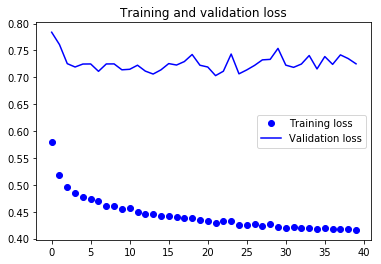

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 409s 818ms/step - loss: 0.5636 - val_loss: 0.7945
Epoch 2/40
500/500 [==============================] - 403s 805ms/step - loss: 0.5150 - val_loss: 0.7649
Epoch 3/40
500/500 [==============================] - 402s 804ms/step - loss: 0.4969 - val_loss: 0.7463
Epoch 4/40
500/500 [==============================] - 402s 804ms/step - loss: 0.4838 - val_loss: 0.7605
Epoch 5/40
500/500 [==============================] - 403s 806ms/step - loss: 0.4726 - val_loss: 0.7803
Epoch 6/40
500/500 [==============================] - 404s 807ms/step - loss: 0.4632 - val_loss: 0.7754
Epoch 7/40
500/500 [==============================] - 403s 805ms/step - loss: 0.4580 - val_loss: 0.7767
Epoch 8/40
500/500 [==============================] - 403s 807ms/step - loss: 0.4513 - val_loss: 0.7725
Epoch 9/40
500/500 [==============================] - 402s 804ms/step - loss: 0.4461 - val_loss: 0.7941
Epoch 10/40
500/500 [==============================] - 404s 807m

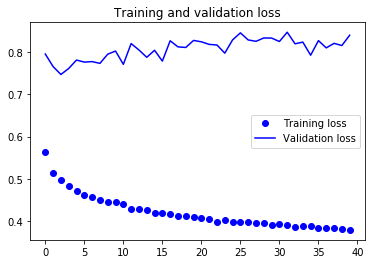

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=60000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=60001,
    max_index=90000,
    step=step,
    batch_size=batch_size)

In [25]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 132s 263ms/step - loss: 0.5801 - val_loss: 0.9313
Epoch 2/20
500/500 [==============================] - 127s 255ms/step - loss: 0.5162 - val_loss: 0.9743
Epoch 3/20
500/500 [==============================] - 127s 255ms/step - loss: 0.4902 - val_loss: 0.9682
Epoch 4/20
500/500 [==============================] - 128s 256ms/step - loss: 0.4734 - val_loss: 0.9120
Epoch 5/20
500/500 [==============================] - 128s 255ms/step - loss: 0.4529 - val_loss: 0.8852
Epoch 6/20
500/500 [==============================] - 29998s 60s/step - loss: 0.4349 - val_loss: 0.9508
Epoch 7/20
500/500 [==============================] - 133s 266ms/step - loss: 0.4180 - val_loss: 0.9228
Epoch 8/20
500/500 [==============================] - 132s 264ms/step - loss: 0.4084 - val_loss: 0.9036
Epoch 9/20
500/500 [==============================] - 134s 269ms/step - loss: 0.3964 - val_loss: 0.8857
Epoch 10/20
500/500 [==============================] - 132s 264m

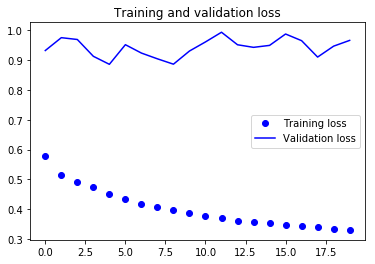

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()